## Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Library

In [ ]:
! pip install praat-parselmouth

In [ ]:
! pip install webrtcvad

## Library import 

In [152]:
import parselmouth
import webrtcvad
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf

import os
import warnings
warnings.filterwarnings('ignore')

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [168]:
path = '/content/drive/MyDrive/Voice_Data/'

In [82]:
os.listdir(path)

['voice.wav', 'cafe_noise.wav', 'Audio', 'parselmouth.ipynb', 'my_audio.wav']

In [83]:
file_name = path+'voice.wav' ## 기존의 음성파일
my_file = path+'my_audio.wav' ## 내가 따라읽은 음성파일

In [85]:
import IPython.display as ipd
ipd.Audio(file_name)

In [86]:
ipd.Audio(my_file)

### Original Audio

Sample Rate:  16000
DATA       :  <class 'numpy.ndarray'> (48944,) [-2.7465820e-04  3.0517578e-05 -1.5258789e-04 ... -6.1035156e-04
 -4.8828125e-04 -7.3242188e-04]
original_file_duration:3.059 sec


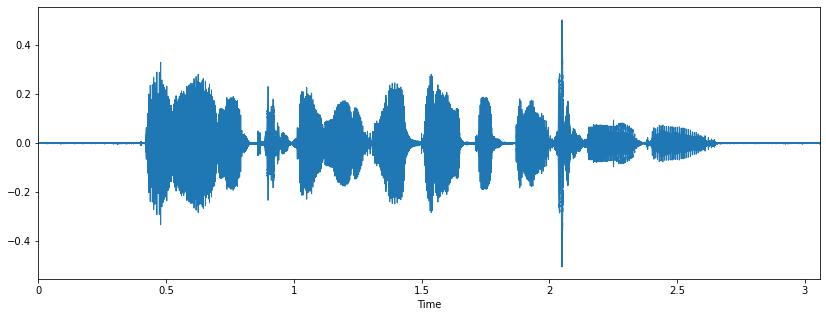

In [194]:
sample1, sample_rate1 = librosa.load(file_name, mono=True, sr=16000)## librosa로 load할 수 있다.

print("Sample Rate: ", sample_rate1)
print("DATA       : ", type(sample1), sample1.shape, sample1) ## sequences는 정규화가 되어서 나온다.
dur = len(sample1)/sample_rate1
print(f"original_file_duration:{dur} sec")

plt.figure(figsize=(14, 5))
librosa.display.waveplot(sample1, sr=sample_rate1)

### My Audio

Sample Rate:  16000
DATA       :  <class 'numpy.ndarray'> (54955,) [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  4.5059505e-06
 -2.7730596e-06  0.0000000e+00]
my_file_duration:3.4347 sec


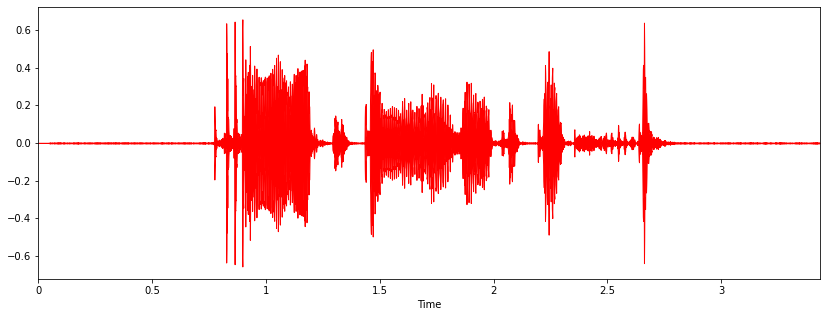

In [157]:
sample2, sample_rate2 = librosa.load(my_file, mono=True, sr=16000)## librosa로 load할 수 있다.

print("Sample Rate: ", sample_rate2)
print("DATA       : ", type(sample2), sample2.shape, sample2) ## sequences는 정규화가 되어서 나온다.
dur = len(sample2)/sample_rate2
print(f"my_file_duration:{dur:.4f} sec")

plt.figure(figsize=(14, 5))
librosa.display.waveplot(sample2, sr=sample_rate2, color='red')

## Webrtcvad

In [292]:
sample_rate, samples = wavfile.read(file_name)
sr, y =wavfile.read(my_file)
y = y.T[0,:]   

import webrtcvad
vad=webrtcvad.Vad()
vad.set_mode(3)

In [300]:
import struct
raw_samples = struct.pack("%dh" % len(samples), *samples)

In [301]:
window_duration = 0.03 # duration in seconds

samples_per_window = int(window_duration * sample_rate1 + 0.5)

bytes_per_sample = 2

In [302]:
segments = []

for i,start in enumerate(np.arange(0, len(samples), samples_per_window)):
    stop = min(start + samples_per_window, len(samples))

    if stop == len(samples):
        break

    print(f"iteration:{i} ==> {start, stop}")

    is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], sample_rate = sample_rate1)
    print(f"is_speech : {is_speech}")
    
    segments.append({'start':start, 'stop':stop, 'is_speech':is_speech})

    

iteration:0 ==> (0, 480)
is_speech : False
iteration:1 ==> (480, 960)
is_speech : False
iteration:2 ==> (960, 1440)
is_speech : False
iteration:3 ==> (1440, 1920)
is_speech : False
iteration:4 ==> (1920, 2400)
is_speech : False
iteration:5 ==> (2400, 2880)
is_speech : False
iteration:6 ==> (2880, 3360)
is_speech : False
iteration:7 ==> (3360, 3840)
is_speech : False
iteration:8 ==> (3840, 4320)
is_speech : False
iteration:9 ==> (4320, 4800)
is_speech : False
iteration:10 ==> (4800, 5280)
is_speech : False
iteration:11 ==> (5280, 5760)
is_speech : False
iteration:12 ==> (5760, 6240)
is_speech : False
iteration:13 ==> (6240, 6720)
is_speech : False
iteration:14 ==> (6720, 7200)
is_speech : True
iteration:15 ==> (7200, 7680)
is_speech : True
iteration:16 ==> (7680, 8160)
is_speech : True
iteration:17 ==> (8160, 8640)
is_speech : True
iteration:18 ==> (8640, 9120)
is_speech : True
iteration:19 ==> (9120, 9600)
is_speech : True
iteration:20 ==> (9600, 10080)
is_speech : True
iteration:21 ==

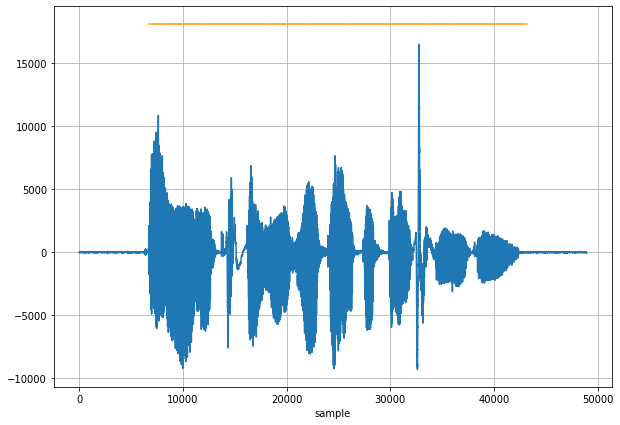

In [271]:
plt.figure(figsize = (10,7))
plt.plot(samples)

ymax = max(samples)


# plot segment identifed as speech
for segment in segments:
    if segment['is_speech']:
        plt.plot([ segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'orange')

plt.xlabel('sample')
plt.grid()

In [274]:
speech_samples = np.concatenate([ samples[segment['start']:segment['stop']] for segment in segments if segment['is_speech']])

import IPython.display as ipd
ipd.Audio(speech_samples, rate=sample_rate)

### Another method for VAD

In [160]:
import webrtcvad
vad = webrtcvad.Vad()
# 1~3 까지 설정 가능, 높을수록 aggressive
vad.set_mode(3)

class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

def frame_generator(frame_duration_ms, audio, sample_rate):
    frames = []
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        frames.append(Frame(audio[offset:offset + n], timestamp, duration))
        timestamp += duration
        offset += n
    
    return frames

# 10, 20, or 30
frame_duration_ms = 10 # ms
frames = frame_generator(frame_duration_ms, sample1, sample_rate1)
for i, frame in enumerate(frames):
    if not vad.is_speech(frame.bytes, sample_rate1):
        print(i, end=' ')

In [161]:
def auto_vad(vad, samples, sample_rate, frame_duration_ms = 10):
    not_speech = []
    frames = frame_generator(frame_duration_ms, sample, sample_rate)
    n_frame = len(frames)
    for idx, frame in enumerate(frames):
        if not vad.is_speech(frame.bytes, sample_rate):
            not_speech.append(idx)
    prior = 0
    cutted_samples = []
    for i in not_speech:
        if i - prior > 2:
            start = int((float(prior) / n_frame) * sample_rate)
            end = int((float(i) / n_frame) * sample_rate)
            print(start, end)
            if len(cutted_samples) == 0:
                cutted_samples = samples[start:end]
            else:
                cutted_samples = np.append(cutted_samples, samples[start:end])
        prior = i
    return cutted_samples

## Parselmouth

In [150]:
snd1 = parselmouth.Sound(file_name)
snd2 = parselmouth.Sound(my_file)

In [303]:
snd1 = snd1[start:end]

(1, 48944)

## Amplitude 

Text(0.5, 1.0, 'my audio')

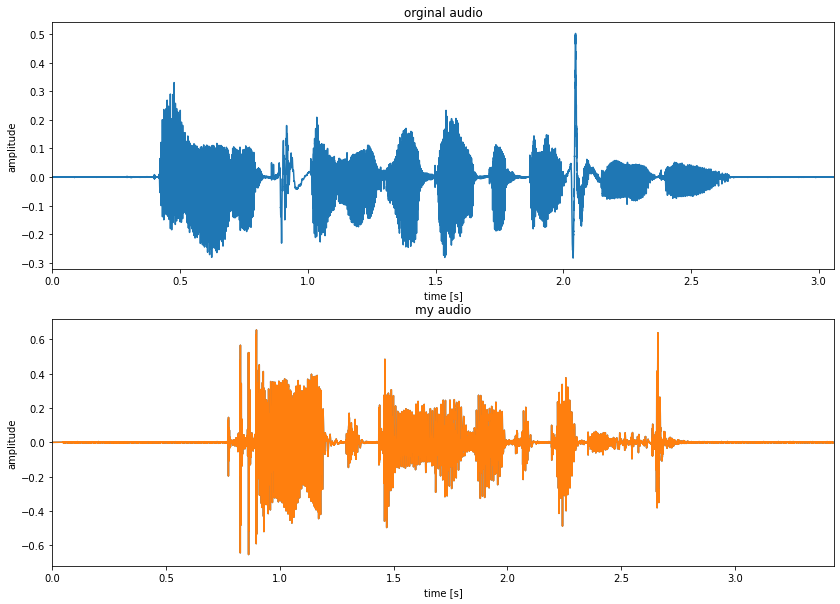

In [100]:
fig,ax = plt.subplots(2,1, figsize=(14,10))


ax[0].plot(snd1.xs(), snd1.values.T)
ax[0].set_xlim([snd1.xmin, snd1.xmax])
ax[0].set_xlabel("time [s]")
ax[0].set_ylabel("amplitude")
ax[0].set_title('orginal audio')

ax[1].plot(snd2.xs(), snd2.values.T)
ax[1].set_xlim([snd2.xmin, snd2.xmax])
ax[1].set_xlabel("time [s]")
ax[1].set_ylabel("amplitude")
ax[1].set_title('my audio')


## VAD & Visualization

In [306]:
 snd_part1 = snd1.extract_part(from_time=0.4, to_time=2.65) ## VAD
 snd_part2 = snd2.extract_part(from_time= 0.7, to_time=2.95 )

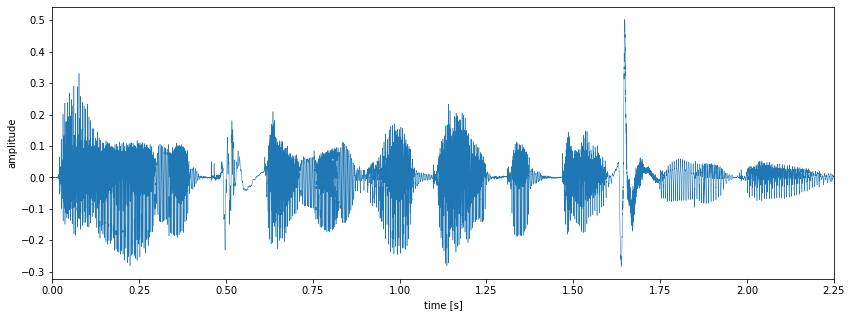

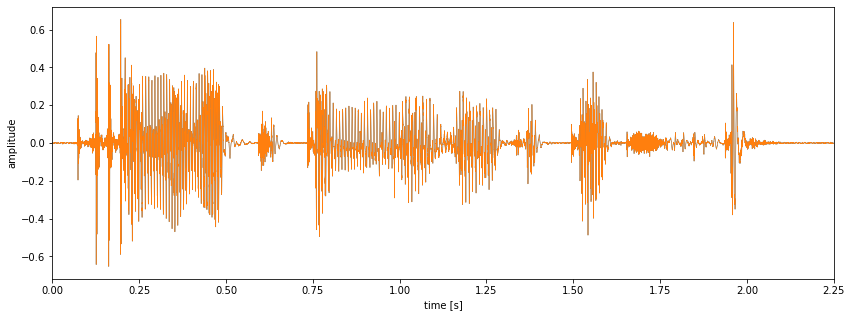

In [307]:
plt.figure(figsize=(14,5))
plt.plot(snd_part1.xs(), snd_part1.values.T, linewidth=0.5)
plt.xlim([snd_part1.xmin, snd_part1.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

plt.figure(figsize=(14,5))
plt.plot(snd_part2.xs(), snd_part2.values.T, linewidth=0.5)
plt.xlim([snd_part2.xmin, snd_part2.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

## Spectrogram & intensity & pitch

In [308]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")


In [314]:
intensity1 = snd_part1.to_intensity()
intensity2 = snd_part2.to_intensity()

spectrogram1 = snd_part1.to_spectrogram()
spectrogram2 = snd_part2.to_spectrogram()

pitch1 = snd_part1.to_pitch()
pitch2 = snd_part2.to_pitch()

### Visualization Spectrogram & intensity

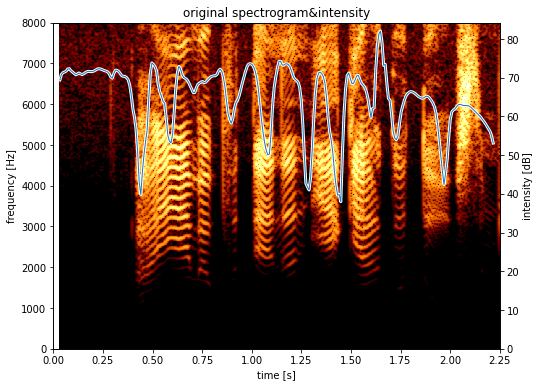

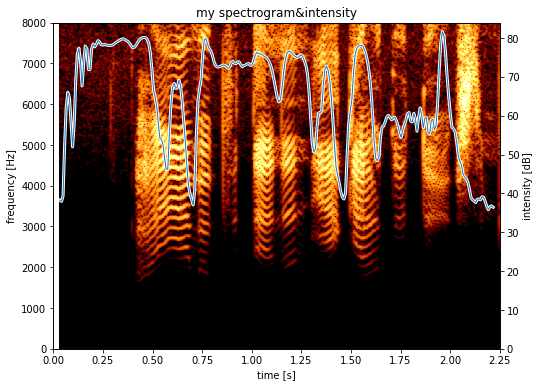

In [343]:
plt.figure(figsize=(8,6))
draw_spectrogram(spectrogram1)
plt.twinx()
draw_intensity(intensity1)
plt.xlim([snd_part1.xmin, snd_part1.xmax])
plt.title('original spectrogram&intensity')
plt.show()


plt.figure(figsize=(8,6))
draw_spectrogram(spectrogram2)
plt.twinx()
draw_intensity(intensity2)
plt.xlim([snd_part2.xmin, snd_part2.xmax])
plt.title('my spectrogram&intensity')
plt.show()

In [344]:
pre_emphasized_snd1 = snd_part1.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram1 = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

pre_emphasized_snd2 = snd_part2.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram2 = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)

### Visualization Spectrogram % Pitch

Text(0.5, 1.0, 'my spectrogram & pitch')

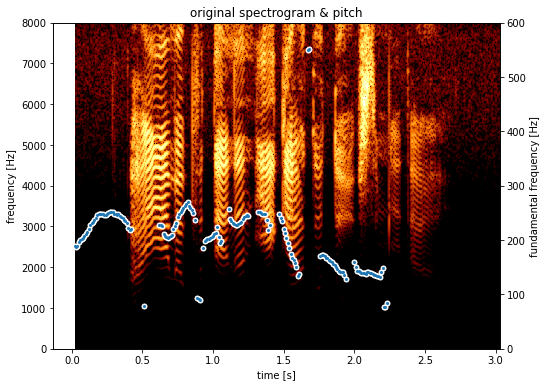

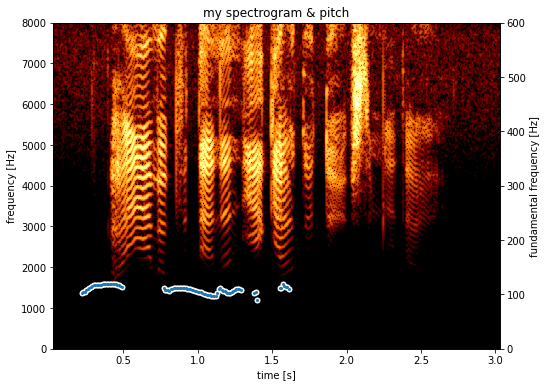

In [318]:
plt.figure(figsize=(8,6))
draw_spectrogram(spectrogram1)
plt.twinx()
draw_pitch(pitch1)
plt.title("original spectrogram & pitch")


plt.figure(figsize=(8,6))
draw_spectrogram(spectrogram2)
plt.twinx()
draw_pitch(pitch2)
plt.title("my spectrogram & pitch")

## Compare 2 Audio(intensity & pitch)

In [319]:
intensity1.values.shape, intensity2.values.shape, pitch1.selected_array['frequency'].shape, pitch2.selected_array['frequency'].shape

((1, 274), (1, 274), (222,), (222,))

In [325]:
intensity_df = pd.DataFrame({'original intensity': intensity1.values.reshape(274,), 'my intensity':intensity2.values.reshape(274,)})
pitch_df = pd.DataFrame({'original pitch': pitch1.selected_array['frequency'], 'my pitch':pitch2.selected_array['frequency']})

In [332]:
intensity_df

,original intensity,my intensity
0,69.440195,38.264822
1,70.860709,37.918947
2,71.344698,39.303867
3,71.473468,52.492541
4,71.710149,62.193529
...,...,...
269,57.506729,36.610570
270,56.847544,35.811600
271,56.184163,36.613530
272,54.980875,36.779764


In [327]:
pitch_df

,original pitch,my pitch
0,189.250276,0.0
1,186.753660,0.0
2,188.349384,0.0
3,195.621881,0.0
4,199.483228,0.0
...,...,...
217,141.978870,0.0
218,148.410448,0.0
219,76.279435,0.0
220,77.017538,0.0


In [333]:
intensity_sub=[]
for a,b in intensity_df.values:
    intensity_sub.append(np.abs(a-b))
    

In [334]:
pitch_sub=[]
for a,b in intensity_df.values:
    pitch_sub.append(np.abs(a-b))
    

max:39.99288910918882, min:0.05970568898706574, mean:11.208106124190092


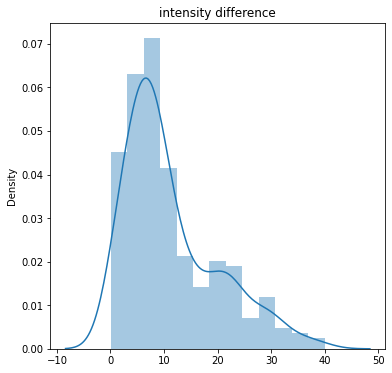

In [340]:
plt.figure(figsize=(6,6))
sns.distplot(intensity_sub)
plt.title("intensity difference")
print(f"max:{np.max(intensity_sub)}, min:{np.min(intensity_sub)}, mean:{np.mean(intensity_sub)}")

max:39.99288910918882, min:0.05970568898706574, mean:11.208106124190092


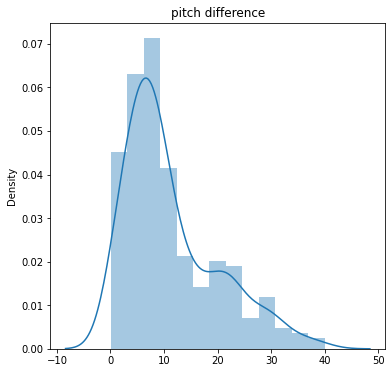

In [341]:
plt.figure(figsize=(6,6))
sns.distplot(pitch_sub)
plt.title("pitch difference")
print(f"max:{np.max(pitch_sub)}, min:{np.min(pitch_sub)}, mean:{np.mean(pitch_sub)}")